# Dec 25th, 2022 (AD: full brain, save a+g)

**Motivation**: save adjacencies and graphs at the level of run, session, animal, and group. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from register.register import Register, reset_ants_img
from sklearn.cluster import KMeans

mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

## Load brain object in N162

In [3]:
brain = 'Symmetric_N162_space-indiv3d_brain.nii.gz'
brain = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, brain),
    pixeltype='unsigned int',
)
brain = brain.numpy()[::-1][:, ::-1]
brain.shape

(60, 46, 81)

## Get files, xtract

In [4]:
files = sorted(filter(
    lambda f: 'sub-DKI' in f or 'sub-WT'in f,
    os.listdir(mice.cfg.raw_dir),
))
len(files)

348

### Masks all

In [5]:
mask_and = np.load(pjoin(tmp_dir, 'AD_mask_and.npy'), mmap_mode='r')
mask_or = np.load(pjoin(tmp_dir, 'AD_mask_or.npy'), mmap_mode='r')

In [6]:
brain[~mask_or] = 0

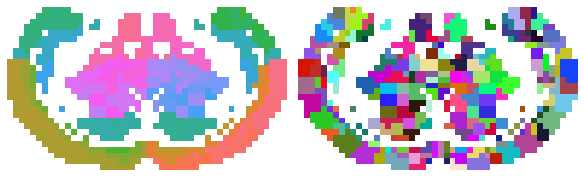

In [7]:
x2p = brain[..., 40].T.copy()
x2p = filter_boundaries(x2p)
for i, r in enumerate(np.unique(x2p[x2p.nonzero()]), start=1):
    x2p[x2p == r] = i
x2p = mwh(x2p == 0, x2p)
fig, axes = create_figure(1, 2, (8, 3), constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=sns.color_palette('husl', as_cmap=True))
axes[1].imshow(mwh(x2p == 0, x2p), cmap=get_rand_cmap(len(np.unique(x2p[x2p.nonzero()]))))
remove_ticks(axes)
plt.show()

In [8]:
regions = np.unique(brain[brain.nonzero()])
node2region = {
    n: r for n, r in
    enumerate(regions)
}
_ = save_obj(
    obj=node2region,
    file_name='AD_n2i',
    save_dir=tmp_dir,
    mode='npy',
)
len(node2region)

[PROGRESS] 'AD_node2region.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

2368

In [9]:
n2l = {}
for n, r in node2region.items():
    info = mice.parcel.get(r)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Data all

In [10]:
data_all = np.load(pjoin(tmp_dir, 'AD_data.npy'), allow_pickle=True).item()
len(data_all)

348

## Save graphs

In [11]:
def _adj2graph(adj):
    a = adj.copy()
    a[np.isnan(a)] = 0
    return nx.from_numpy_array(a)

## Each run separately

In [12]:
percentiles = [5, 10, 15, 20, 25]
n_samples = 10
adj_all, threshold_all = {}, {}
for key, data in tqdm(data_all.items()):
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0

        adj_all[key] = a
        threshold_all[key] = th

        path = '_'.join([
            f"n-{mice.cfg.nn}*{mice.cfg.ll}",
            'bp(0.008,0.28)_bold_rest_pearson',
            key,
        ])
        path = pjoin(mice.cfg.svinet_dir, path, 'real')
        save_graph(_adj2graph(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/348 [00:00<?, ?it/s]

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

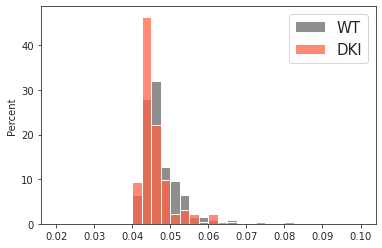

In [25]:
_x = [v for k, v in threshold_all.items() if 'WT' in k]
sns.histplot(_x, color='dimgrey', label='WT', bins=np.linspace(0.02, 0.1, 33), stat='percent')
_x = [v for k, v in threshold_all.items() if 'DKI' in k]
sns.histplot(_x, color='tomato', label='DKI', bins=np.linspace(0.02, 0.1, 33), stat='percent')
plt.legend(fontsize=15)
plt.show()

## Session level

In [44]:
sessions = []
for k in data_all:
    sessions.append('_'.join(k.split('_')[:2]))
sessions = sorted(set(sessions))
len(sessions)

118

In [62]:
for key in tqdm(sessions):
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0

        adj_all[key] = a
        threshold_all[key] = th

        path = '_'.join([
            f"n-{mice.cfg.nn}*{mice.cfg.ll}",
            'bp(0.008,0.28)_bold_rest_pearson',
            key,
        ])
        path = pjoin(mice.cfg.svinet_dir, path, 'real')
        save_graph(_adj2graph(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/118 [00:00<?, ?it/s]

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [64]:
len(adj_all)

466

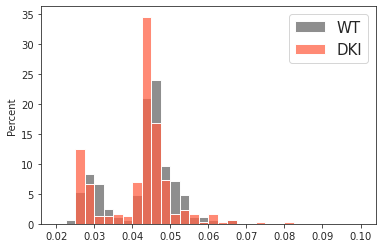

In [63]:
_x = [v for k, v in threshold_all.items() if 'WT' in k]
sns.histplot(_x, color='dimgrey', label='WT', bins=np.linspace(0.02, 0.1, 33), stat='percent')
_x = [v for k, v in threshold_all.items() if 'DKI' in k]
sns.histplot(_x, color='tomato', label='DKI', bins=np.linspace(0.02, 0.1, 33), stat='percent')
plt.legend(fontsize=15)
plt.show()

## Animal level

In [65]:
animals = []
for k in data_all:
    animals.append(k.split('_')[0])
animals = sorted(set(animals))
len(animals)

69

In [75]:
for key in tqdm(animals):
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0

        adj_all[key] = a
        threshold_all[key] = th

        path = '_'.join([
            f"n-{mice.cfg.nn}*{mice.cfg.ll}",
            'bp(0.008,0.28)_bold_rest_pearson',
            key,
        ])
        path = pjoin(mice.cfg.svinet_dir, path, 'real')
        save_graph(_adj2graph(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)

  0%|          | 0/69 [00:00<?, ?it/s]

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [76]:
len(adj_all)

535

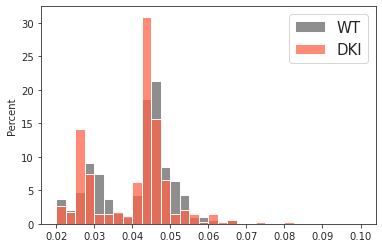

In [77]:
_x = [v for k, v in threshold_all.items() if 'WT' in k]
sns.histplot(_x, color='dimgrey', label='WT', bins=np.linspace(0.02, 0.1, 33), stat='percent')
_x = [v for k, v in threshold_all.items() if 'DKI' in k]
sns.histplot(_x, color='tomato', label='DKI', bins=np.linspace(0.02, 0.1, 33), stat='percent')
plt.legend(fontsize=15)
plt.show()

## Group level

In [78]:
groups = []
for k in data_all:
    g = k.split('_')[0].split('-')[1]
    g = re.findall("[a-zA-Z]+", g).pop()
    groups.append(g)
groups = sorted(set(groups))
len(groups)

2

In [79]:
%%time

for key in groups:
    data = np.concatenate(list(map(
        operator.itemgetter(1),
        filter(lambda t: key in t[0], data_all.items())
    )), axis=-1)
    print(key, data.shape)
    a, _ = get_adj_mat(data, 'pearson', p_val=1)
    thresholds = calculate_threshold(
        a, [p / 100 for p in percentiles])
    for perc, th in zip(percentiles, thresholds):
        ab = dc(a)
        ab[a <= th] = 0

        adj_all[key] = a
        threshold_all[key] = th

        path = '_'.join([
            f"n-{mice.cfg.nn}*{mice.cfg.ll}",
            'bp(0.008,0.28)_bold_rest_pearson',
            key,
        ])
        path = pjoin(mice.cfg.svinet_dir, path, 'real')
        save_graph(_adj2graph(ab), perc, path, n_samples)

_ = save_obj(
    obj=adj_all,
    file_name='AD_adj',
    save_dir=tmp_dir,
    mode='npy',
)

DKI
(2368, 66239)

WT
(2368, 37141)

[PROGRESS] 'AD_adj.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

CPU times: user 3min 26s, sys: 1min 30s, total: 4min 56s
Wall time: 23min 46s


In [80]:
len(adj_all)

537

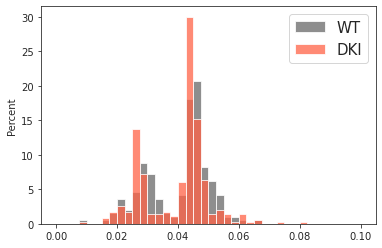

In [81]:
_x = [v for k, v in threshold_all.items() if 'WT' in k]
sns.histplot(_x, color='dimgrey', label='WT', bins=np.linspace(0.0, 0.1, 41), stat='percent')
_x = [v for k, v in threshold_all.items() if 'DKI' in k]
sns.histplot(_x, color='tomato', label='DKI', bins=np.linspace(0.0, 0.1, 41), stat='percent')
plt.legend(fontsize=15)
plt.show()

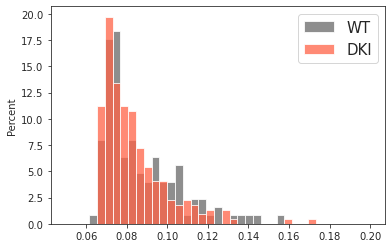

In [134]:
# Was cortex only

## Now running this:

time ./loop_svinet.sh 128 3 10 p25-sample 500 bold rest "0.008,0.28" pearson "sub[-_0-9a-zA-Z]*"